In [1]:
# Install Kaggle API
!pip install kaggle

# Move the uploaded kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions


In [2]:
# Download dataset from Kaggle
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

# Unzip the dataset
!unzip -o lgg-mri-segmentation.zip -d lgg-mri-segmentation


Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1

In [3]:
!pip install segmentation-models-pytorch torch torchvision albumentations numpy


  Using cached segmentation_models_pytorch-0.4.0-py3-none-any.whl.metadata (32 kB)
  Using cached efficientnet_pytorch-0.7.1-py3-none-any.whl
  Using cached pretrainedmodels-0.7.4-py3-none-any.whl
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached munch-4.0.

In [4]:
import os
import glob
from PIL import Image
import numpy as np

# Define dataset path
dataset_path = "lgg-mri-segmentation/kaggle_3m"

# Get all MRI and mask files
all_tif_files = glob.glob(f"{dataset_path}/**/*.tif", recursive=True)

# Separate MRI scans and masks (assuming masks contain "_mask" in filename)
mri_files = sorted([f for f in all_tif_files if "_mask" not in f])
mask_files = sorted([f for f in all_tif_files if "_mask" in f])

# Print sample file names
print("✅ First MRI Image:", mri_files[0])
print("✅ First Mask Image:", mask_files[0])


✅ First MRI Image: lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
✅ First Mask Image: lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif


In [5]:
import torch
from torchvision import transforms

# Define preprocessing function
def preprocess_image(image_path, mask=False):
    """Load, resize, normalize, and convert MRI scans & masks to tensors."""
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    image = image.resize((128, 128))  # Resize to match model input

    image_array = np.array(image) / 255.0  # Normalize pixel values to 0-1

    if mask:  # Masks are binary (0 or 1)
        image_array = (image_array > 0.5).astype(np.float32)  # Convert to binary mask

    image_tensor = torch.tensor(image_array, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
    return image_tensor


In [15]:
from torch.utils.data import Dataset, DataLoader

class BrainMRIDataset(Dataset):
    """Custom PyTorch Dataset for MRI Segmentation"""
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        mri_image = preprocess_image(self.image_paths[idx])  # Load MRI scan
        mask_image = preprocess_image(self.mask_paths[idx], mask=True)  # Load segmentation mask

        # ✅ Ensure shape is (1, H, W) — no extra dimension
        mri_image = mri_image.unsqueeze(0)  # (1, 128, 128)
        mask_image = mask_image.unsqueeze(0)  # (1, 128, 128)

        return mri_image, mask_image

# ✅ Create dataset
dataset = BrainMRIDataset(mri_files, mask_files)

# ✅ Create DataLoader (Batch, 1, 128, 128)
batch_size = 32  # Increase batch size for speed
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


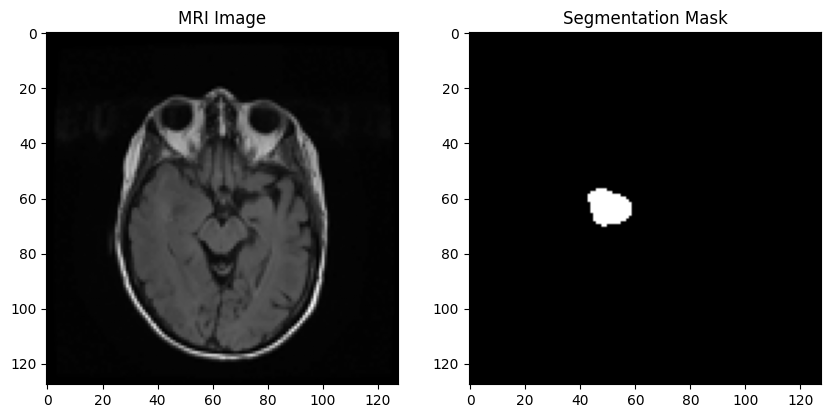

In [16]:
import matplotlib.pyplot as plt

# Get a batch of MRI scans and masks
mri_batch, mask_batch = next(iter(dataloader))

# Convert to NumPy for visualization
mri_sample = mri_batch[0].squeeze().numpy()
mask_sample = mask_batch[0].squeeze().numpy()

# Display MRI and Mask
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("MRI Image")
plt.imshow(mri_sample, cmap="gray")

plt.subplot(1,2,2)
plt.title("Segmentation Mask")
plt.imshow(mask_sample, cmap="gray")

plt.show()


In [17]:
import torch
import segmentation_models_pytorch as smp

# Define U-Net++ model
model = smp.UnetPlusPlus(
    encoder_name="resnet34",   # Choose EfficientNet, ResNet, etc.
    encoder_weights="imagenet",  # Use pre-trained weights
    in_channels=1,  # Grayscale MRI
    classes=1,  # Binary segmentation (tumor vs. background)
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model summary
print(model)


UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [20]:
import time
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler

scaler = GradScaler("cuda")  # ✅ Use correct AMP version

# ✅ Define loss function
criterion = nn.BCEWithLogitsLoss()

# ✅ Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_model(model, train_loader, num_epochs=5):
    model.train()

    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        batch_count = len(train_loader)

        print(f"\n🚀 Epoch {epoch+1}/{num_epochs} -------------------")

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)

            # ✅ Ensure correct shape (Batch, 1, 128, 128)
            if images.dim() == 5:  # If extra dimension exists
                images = images.squeeze(1)
                masks = masks.squeeze(1)

            # ✅ Use AMP for faster training
            with autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, masks)

            # ✅ Backward pass with mixed precision
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"  🔄 Batch {batch_idx+1}/{batch_count} - Loss: {loss.item():.4f}")

        epoch_time = time.time() - start_time
        print(f"✅ Epoch {epoch+1} Finished - Loss: {running_loss:.4f}, Time: {epoch_time:.2f} sec")

# ✅ Train model with AMP
train_model(model, dataloader, num_epochs=5)



🚀 Epoch 1/5 -------------------
  🔄 Batch 10/123 - Loss: 0.6004
  🔄 Batch 20/123 - Loss: 0.5066
  🔄 Batch 30/123 - Loss: 0.4353
  🔄 Batch 40/123 - Loss: 0.3853
  🔄 Batch 50/123 - Loss: 0.3452
  🔄 Batch 60/123 - Loss: 0.3126
  🔄 Batch 70/123 - Loss: 0.2927
  🔄 Batch 80/123 - Loss: 0.2651
  🔄 Batch 90/123 - Loss: 0.2506
  🔄 Batch 100/123 - Loss: 0.2370
  🔄 Batch 110/123 - Loss: 0.2264
  🔄 Batch 120/123 - Loss: 0.2141
✅ Epoch 1 Finished - Loss: 43.7146, Time: 36.53 sec

🚀 Epoch 2/5 -------------------
  🔄 Batch 10/123 - Loss: 0.1979
  🔄 Batch 20/123 - Loss: 0.2012
  🔄 Batch 30/123 - Loss: 0.1972
  🔄 Batch 40/123 - Loss: 0.1995
  🔄 Batch 50/123 - Loss: 0.1816
  🔄 Batch 60/123 - Loss: 0.1721
  🔄 Batch 70/123 - Loss: 0.1669
  🔄 Batch 80/123 - Loss: 0.1617
  🔄 Batch 90/123 - Loss: 0.1552
  🔄 Batch 100/123 - Loss: 0.1608
  🔄 Batch 110/123 - Loss: 0.1458
  🔄 Batch 120/123 - Loss: 0.1515
✅ Epoch 2 Finished - Loss: 21.5414, Time: 26.20 sec

🚀 Epoch 3/5 -------------------
  🔄 Batch 10/123 - Loss

In [21]:
# Save the trained model
torch.save(model.state_dict(), "unetplusplus_mri_segmentation.pth")
print("✅ Model saved successfully!")


✅ Model saved successfully!


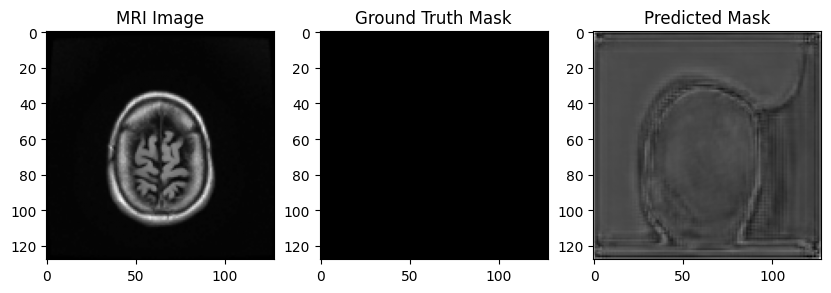

In [24]:
import matplotlib.pyplot as plt

# Load a batch of test images
test_images, test_masks = next(iter(dataloader))

# Select one test image (Ensure correct shape)
test_image = test_images[0].unsqueeze(0).squeeze(1).to(device)  # Remove extra channel dimension

# Get model prediction
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predicted_mask = model(test_image)

# Convert tensors to numpy for visualization
test_image = test_image.cpu().squeeze().numpy()
test_mask = test_masks[0].cpu().squeeze().numpy()
predicted_mask = predicted_mask.cpu().squeeze().numpy()

# Display MRI, Ground Truth, and Prediction
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title("MRI Image")
plt.imshow(test_image, cmap="gray")

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(test_mask, cmap="gray")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap="gray")

plt.show()


In [25]:
# Load trained model
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights=None,  # No need for pre-trained weights
    in_channels=1,
    classes=1
)
model.load_state_dict(torch.load("unetplusplus_mri_segmentation.pth"))
model.to(device)
model.eval()  # Set model to evaluation mode

print("✅ Model reloaded successfully!")


✅ Model reloaded successfully!


<ipython-input-25-8f7201761bbe>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unetplusplus_mri_segmentation.pth"))


In [27]:
from sklearn.metrics import accuracy_score, jaccard_score

def evaluate_model(model, dataloader):
    model.eval()
    total_accuracy = 0.0
    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            # ✅ Fix: Ensure images are 4D (Batch, 1, 128, 128)
            if images.dim() == 5:
                images = images.squeeze(1)  # Remove extra channel dim
                masks = masks.squeeze(1)

            # Get model predictions
            predictions = model(images)
            predictions = (predictions > 0.5).float()  # Convert logits to binary mask

            # Flatten for accuracy computation
            true_mask = masks.cpu().numpy().flatten()
            pred_mask = predictions.cpu().numpy().flatten()

            # Compute accuracy and IoU
            batch_accuracy = accuracy_score(true_mask, pred_mask)
            batch_iou = jaccard_score(true_mask, pred_mask, average='binary')

            total_accuracy += batch_accuracy
            total_iou += batch_iou
            num_samples += 1

    avg_accuracy = total_accuracy / num_samples
    avg_iou = total_iou / num_samples

    return avg_accuracy, avg_iou

# ✅ Evaluate model
accuracy, iou = evaluate_model(model, dataloader)
print(f"✅ Model Accuracy: {accuracy:.4f}")
print(f"✅ Model IoU Score: {iou:.4f}")


✅ Model Accuracy: 0.9948
✅ Model IoU Score: 0.5292
